In [81]:
# Part 1
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import isodate 

# The function used to collect recipe data from the given URL
def collect_page_data(recipe_url):
    try:
        # Used to send the request to fetch the webpage
        response = requests.get(recipe_url)
        html = response.text  # This retrieves the HTML content of the page
        soup = BeautifulSoup(html, "html.parser")  # This is used to parse the HTML
        script = soup.find("script", type="application/ld+json")  # This is used to locate the JSON data which is embedded in the page
        
        # If there is no JSON data found, the system will print a message and return None
        if not script:
            print(f"Sorry there is no JSON data found for URL: {recipe_url}")
            return None
        
        # This loads the JSON data from the script tag
        json_information = json.loads(script.string)
        
        # This will check if the JSON data has the expected structure for a recipe
        if isinstance(json_information, dict) and "@graph" in json_information:
            recipe = next((item for item in json_information["@graph"] if item.get("@type") == "Recipe"), None)
        else:
            recipe = json_information if json_information.get("@type") == "Recipe" else None

        # If there is no recipe data is found, a message is printed and "None" is returned
        if not recipe:
            print(f"Sorry there is no valid recipe data found for URL: {recipe_url}")
            return None
        
    # Should an issue occur with the JSON decode or scrape then print and display the error as well as return None
    except (json.JSONDecodeError, ValueError, KeyError) as e:
        print(f"An error has occurred whilst processing JSON or scraping the data for URL: {recipe_url} with the error: {e}")
        return None

    # Try to safely extra the data that we need
    try:
        # Extract the title of the recipe
        title = recipe.get("name", "Unknown")
        
        # Extract the preparation and cooking time
        prep_info = recipe.get("prepTime", "")
        cook_info = recipe.get("cookTime", "")
        
        # Convert the preparation and cooking time to minutes
        prep_mins = int(isodate.parse_duration(prep_info).total_seconds() / 60) if prep_info else 0
        cook_mins = int(isodate.parse_duration(cook_info).total_seconds() / 60) if cook_info else 0
        final_time = prep_mins + cook_mins  # Store the final total time
        
        total_time = f"{final_time} mins"  # Store the total time in a readable format for the user
        
        # Extract the image URL of the recipe
        image_info = recipe.get("image", {})
        image = image_info.get("url", "Sorry, no image was found!") if isinstance(image_info, dict) else image_info

        # Extract the list of ingredients for the recipe
        ingredients = recipe.get("recipeIngredient", [])
        
        # Extract rating information
        rating_info = recipe.get("aggregateRating", {})
        rating_val = rating_info.get("ratingValue")
        rating_count = rating_info.get("ratingCount")
        
        # Extract category and cuisine
        category = recipe.get("recipeCategory", "Unknown")
        cuisine = recipe.get("recipeCuisine", "Unknown")
        
        # Extract diet information
        list_diet = recipe.get("suitableForDiet", [])
        diet_label = [d.split('/')[-1] for d in list_diet]  # Extract diet labels
        vegan = "VeganDiet" in diet_label  # Check if the recipe is vegan
        vegetarian = "VegetarianDiet" in diet_label  # Check if the recipe is vegetarian
        diet = diet_label  # List of all diet types for this recipe

        # Create a dictionary with all extracted data
        data = {
            "title": title,
            "total_time": total_time,
            "image": image,
            "ingredients": ingredients,
            "rating_val": rating_val,
            "rating_count": rating_count,
            "category": category,
            "cuisine": cuisine,
            "diet": diet,
            "vegan": vegan,
            "vegetarian": vegetarian,
            "url": recipe_url
        }
        
        # Return the data as a DataFrame
        return pd.DataFrame([data])  # Return the DataFrame
    
    # If there are any errors during the data extraction, print the error and return None
    except Exception as e:
        print(f"An error has occurred whilst extracting or processing the data for URL: {recipe_url} with the error: {e}")
        return None

# Main part of the script where we call the function
if __name__ == "__main__":
    # List of recipe URLs to scrape the data from
    urls = [
        "https://www.bbc.co.uk/food/recipes/avocado_pasta_with_peas_31700",
        "https://www.bbc.co.uk/food/recipes/easiest_ever_banana_cake_42108",
        "https://www.bbc.co.uk/food/recipes/sweet_potatoes_beans_68614"
    ]
    
    data_list = []  # List to store data from all recipes
    
    # Loop through each URL and collect the data
    for url in urls:
        df = collect_page_data(url)  # Get data for each recipe
        if df is not None:  # Only append valid data to the list
            data_list.append(df)
        else:
            print(f"An error occurred therefore skipping URL: {url}")
    
    # If there is any valid data collected, combine it into a single DataFrame
    if data_list:
        df = pd.concat(data_list, ignore_index=True)  # Combine all DataFrames into one
        
        # Save the combined DataFrame to a CSV file
        df.to_csv("bbc_recipes.csv", index=False)
        
        # Display the final combined DataFrame
        print(df)
    else:
        print("There is no valid recipe data collected.")


                                              title total_time  \
0                 Avocado pasta with peas and mint     40 mins   
1                          Easiest ever banana cake    90 mins   
2  Roasted sweet potatoes with chipotle black beans    90 mins   

                                                                                             image  \
0   https://ichef.bbci.co.uk/food/ic/food_16x9_1600/recipes/avocado_pasta_with_peas_31700_16x9.jpg   
1  https://ichef.bbci.co.uk/food/ic/food_16x9_1600/recipes/easiest_ever_banana_cake_42108_16x9.jpg   
2      https://ichef.bbci.co.uk/food/ic/food_16x9_1600/recipes/sweet_potatoes_beans_68614_16x9.jpg   

                                                                                                                                                                                                                                                                                                                                      

In [9]:
# Part 2.1
import pandas as pd
import matplotlib.pyplot as ply
import seaborn as sns

file_path = "recipes.csv"
recipes_df = pd.read_csv(file_path)

if 'Unnamed: 0' in recipes_df.columns:
    recipes_df.drop(columns=['Unnamed: 0'], inplace=True)



# Check for empty strings or strings with only spaces
for col in recipes_df.select_dtypes(include=['object']).columns:  # Only check text columns
    recipes_df[col] = recipes_df[col].apply(lambda x: None if isinstance(x, str) and x.strip() == "" else x)

# Now check for missing values
missing_values = recipes_df.isnull().sum()
print("Missing values (including empty strings):\n", missing_values, "\n")

# Ensure missing values are removed
recipes_df.dropna(inplace=True)

# checks that missing have benn removed
missing_values = recipes_df.isnull().sum()
print("Missing values (including empty strings):\n", missing_values, "\n")


# Show summary statistics
print("\nSummary Statistics:\n", recipes_df.describe())

# Get the 10 highest-rated recipes, prioritizing those with more ratings
top_rated_recipes = recipes_df.sort_values(by=['rating_avg', 'rating_val'], ascending=[False, False]).head(10)

# Display the result
print("\nTop 10 Highest Rated Recipes (Considering Number of Reviews):\n")
for i, row in enumerate(top_rated_recipes.itertuples(), start=1):
    print(f"{i}. {row.title} - Rating: {row.rating_avg} ({row.rating_val} ratings)")

Missing values (including empty strings):
 id                0
title             0
image_url         0
recipe_url        0
rating_avg        0
rating_val        0
total_time        0
category         50
cuisine        1419
ingredients       0
dtype: int64 

Missing values (including empty strings):
 id             0
title          0
image_url      0
recipe_url     0
rating_avg     0
rating_val     0
total_time     0
category       0
cuisine        0
ingredients    0
dtype: int64 


Summary Statistics:
                 id   rating_avg   rating_val   total_time
count  1842.000000  1842.000000  1842.000000  1842.000000
mean   1686.340391     4.502772    13.615092   134.039088
std     942.609415     0.603506    24.668339   166.202022
min       3.000000     1.000000     1.000000    30.000000
25%     912.250000     4.250000     3.000000    60.000000
50%    1709.000000     4.687500     7.000000    90.000000
75%    2489.750000     5.000000    15.000000   150.000000
max    3293.000000     5.000

In [2]:
# part 2.2
import numpy as np


average_ratings = recipes_df.groupby("title")["rating_avg"].mean().reset_index()
top_10_avg_ratings = average_ratings.nlargest(10, 'rating_avg')

print("\nTop 10 Highest Average Rated Recipes:\n")
print(top_10_avg_ratings[['title', 'rating_avg']])

bootstrap_samples = 1000  # Number of bootstrap samples
sample_size = 100         # Sample size for each bootstrap iteration
bootstrap_means = []

for _ in range(bootstrap_samples):
    sample = recipes_df['rating_avg'].sample(n=sample_size, replace=True)
    bootstrap_means.append(sample.mean())

ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)

# Print the confidence interval
print(f"\n95% Confidence Interval for Average Ratings: ({ci_lower:.2f}, {ci_upper:.2f})")


Top 10 Highest Average Rated Recipes:

                               title  rating_avg
1              'Lion head' meatballs         5.0
4                  All-in-one turkey         5.0
7           Aloo gobi and jeera rice         5.0
8                       Alpine pizza         5.0
10         American baked cheesecake         5.0
12   Angel food cake with lemon curd         5.0
14         Apple and Wensleydale pie         5.0
15  Apple and passion fruit tartlets         5.0
18         Apple and rhubarb muffins         5.0
23                       Apple momos         5.0

95% Confidence Interval for Average Ratings: (4.38, 4.62)



Summary Statistics of Ratings:
         rating_avg   rating_val
count  3293.000000  3293.000000
mean      4.497432    12.038567
std       0.611602    25.221305
min       1.000000     1.000000
25%       4.250000     3.000000
50%       4.666667     6.000000
75%       5.000000    13.000000
max       5.000000   776.000000


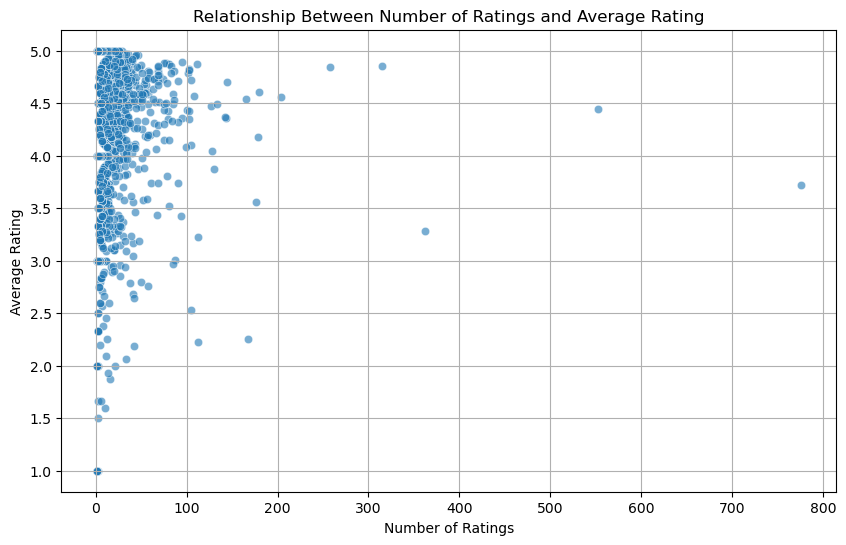

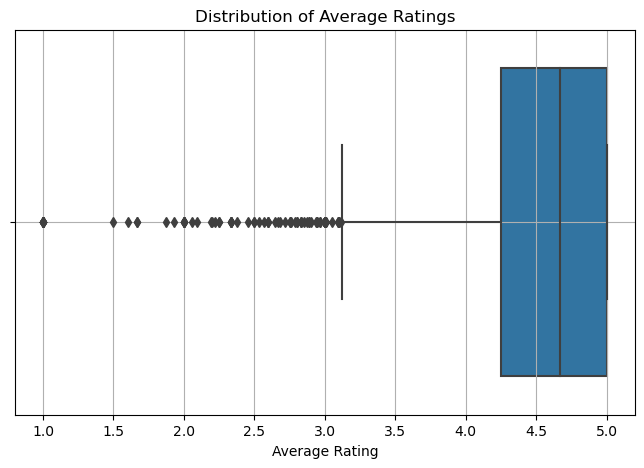

Quantile Threshold Testing:

- Using 30th percentile : Threshold = 3 ratings
   Recipes kept: 2581 (78.4% of dataset)

- Using 40th percentile : Threshold = 5 ratings
   Recipes kept: 2002 (60.8% of dataset)

- Using 50th percentile : Threshold = 6 ratings
   Recipes kept: 1753 (53.2% of dataset)

- Using 60th percentile : Threshold = 8 ratings
   Recipes kept: 1403 (42.6% of dataset)

- Using 70th percentile : Threshold = 11 ratings
   Recipes kept: 1037 (31.5% of dataset)

To decide on a good threshold for the number of ratings, I tested different quantiles from 0.3 to 0.7
The goal was to find the minimum number of ratings required while still keeping a good portion of the data for recommendations.

At the 0.3 and 0.4 quantiles, the thresholds were 3 and 5 ratings, keeping 78% and 61% of the data respectively.
However, these thresholds are too low, and many of the ratings might not be reliable.

At the 0.5 quantile (the median), the threshold is 6 ratings, and 53% of the data is kept

In [80]:
# Part 2.3
import matplotlib.pyplot as plt

# Ensure 'rating_avg' and 'rating_val' columns are numeric
# This is for accurate calculations, plotting, and filtering
# 'errors="coerce"' will convert any non-numeric values (e.g., strings) to NaN
recipes_df["rating_avg"] = pd.to_numeric(recipes_df["rating_avg"], errors='coerce')
recipes_df["rating_val"] = pd.to_numeric(recipes_df["rating_val"], errors='coerce')


# Display summary statistics for average rating and number of ratings (mean, std, min, max, etc.)
print("\nSummary Statistics of Ratings:\n", recipes_df[['rating_avg', 'rating_val']].describe())

# Create a scatter plot to visualize the relationship between average rating and number of ratings

plt.figure(figsize=(10, 6)) # Create a figure with width 10 and height 6 inches
sns.scatterplot(x='rating_val', y='rating_avg', data=recipes_df, alpha=0.6) # Plot points showing number of ratings vs. average rating
plt.xlabel("Number of Ratings") # Label for the x-axis
plt.ylabel("Average Rating") # Label for the y-axis
plt.title("Relationship Between Number of Ratings and Average Rating") # Plot title
plt.grid(True)   # Show grid lines for better readability
plt.show()  # Display the scatter plot


# Create a box plot to show the distribution of average ratings
# Useful for spotting outliers and understanding the range of ratings
plt.figure(figsize=(8, 5)) # Create a figure with width 8 and height 5 inches
sns.boxplot(x=recipes_df["rating_avg"])   # Create a horizontal box plot for average ratings
plt.title("Distribution of Average Ratings")  # Plot title
plt.xlabel("Average Rating")  # Label for the x-axis
plt.grid(True)  # Show grid lines for better readability
plt.show()  # Display the scatter plot


# print out a text
print("Quantile Threshold Testing:\n")

## Test different quantiles to determine a suitable threshold for number of ratings
for q in [0.3, 0.4, 0.5, 0.6, 0.7]:
    # Calculate the rating count threshold based on the current quantile
    threshold = recipes_df['rating_val'].quantile(q)
    # Keep only recipes that meet or exceed the threshold
    kept = recipes_df[recipes_df['rating_val'] >= threshold]
    # Calculate the percentage of recipes
    percent_kept = len(kept) / len(recipes_df) * 100
    # Dsiplay the treshhold and how much of recipes retained in percnetage
    print(f"- Using {int(q*100)}th percentile : Threshold = {int(threshold)} ratings")
    print(f"   Recipes kept: {len(kept)} ({percent_kept:.1f}% of dataset)\n")

print(
    "To decide on a good threshold for the number of ratings, I tested different quantiles from 0.3 to 0.7\n"
    "The goal was to find the minimum number of ratings required while still keeping a good portion of the data for recommendations.\n\n"
    "At the 0.3 and 0.4 quantiles, the thresholds were 3 and 5 ratings, keeping 78% and 61% of the data respectively.\n"
    "However, these thresholds are too low, and many of the ratings might not be reliable.\n\n"
    "At the 0.5 quantile (the median), the threshold is 6 ratings, and 53% of the data is kept.\n"
    "This offers a fair balance between keeping useful data and filtering out weak results.\n\n"
    "At 0.6 and 0.7 quantiles, the thresholds were 8 and 11 ratings, and only 42% and 31% of the data were kept.\n"
    "These are too strict and would limit the variety of recipes we can recommend.\n\n"
    "So overall, using the median (0.5 quantile = 6 ratings) is a good middle ground — reliable enough without being too restrictive."
)

In [78]:
# Part 2.4
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Set display option to allows full text display
pd.set_option('display.max_colwidth', None)

# Define the selected features to be combined
features = ['title', 'rating_avg', 'rating_val', 'total_time', 'category', 'cuisine', 'ingredients']

# Ensure all selected features columns to string typa and change any empty string to none values
for feature in features:
    recipes_df[feature] = recipes_df[feature].fillna('').astype(str)

# Combines all selected featues into one string per row
recipes_df['combine_features'] = recipes_df[features].apply(lambda row: ' '.join(row), axis=1)

# Display the top 10 combined features for verification 
for index, row in recipes_df[['combine_features']].head(10).iterrows():
    print(f"{index}: {row['combine_features']}")


# Cosine Similarity

# Create a count matrix using CountVectorizer 
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(recipes_df['combine_features'])

# Compute the cosine similarity matrix (measures similarity between each pair of recipes)
cosine_sim = cosine_similarity(count_matrix)


# Recommendations using a Matrix-Vector Product

# define recipes the user likes 
target_recipe = "Chicken and coconut curry"

# Check if the target recipe exists in the dataset
matching_rows = recipes_df[recipes_df['title'] == target_recipe]
if matching_rows.empty:
    print(f"The recipe '{target_recipe}' was not found in the dataset.")
else:
    # Get the index of the target recipe
    target_index = matching_rows.index[0]

    # Create a user preference vector (1 for liked recipe, 0 for all others
    user_vector = np.zeros(recipes_df.shape[0])
    user_vector[target_index] = 1

   # Calculate recommendation scores by multiplying the cosine similarity matrix by the user vector
    scores = cosine_sim.dot(user_vector)

    # Sort scores in descending order and exclude the target recipe itself
    sorted_indices = np.argsort(scores)[::-1]
    sorted_indices = [idx for idx in sorted_indices if idx != target_index]
    top_recommendations = sorted_indices[:10]

    # Display the top 10 most similar recipes
    print(f"\nTop 10 recommendations for the recipe '{target_recipe}':")
    for i, idx in enumerate(top_recommendations, start=1):
        recommended_title = recipes_df.iloc[idx]['title']
        print(f"{i}. {recommended_title} (Score: {scores[idx]:.2f})")

0: A classic sponge cake 4.285714286 7 90 Cakes and baking   passion fruit, fromage frais, egg, mascarpone, caster sugar, baking powder, self-raising flour, vanilla extract, butter
1: Adaptable bean soup 5.0 11 60 Light meals & snacks   orange, swiss chard, onion, carrot, tomato, olive oil, parmesan, parsley, black pepper, bay leaf, vegetable stock, cannellini beans, French bread
2: Affogato 4.0 6 30 Desserts Italian ice cream, coffee granules
3: Albanian baked lamb with rice (Tavë kosi) 4.611111111 18 150 Main course East European lamb shoulder, garlic, olive oil, egg, yoghurt, black pepper, nutmeg, oregano, long-grain rice, butter, plain flour
4: All-day breakfast frittata 5.0 10 60 Main course   bacon, potato, cherry tomatoes, mushroom, spinach, vegetable oil, egg, black pepper
5: All-in-one turkey 5.0 3 180 Main course British turkey breast, pancetta, dried apricots, apple, garlic, red onion, shallot, spinach, chestnut mushrooms, olive oil, double cream, mascarpone, flour, sugar, p

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# recipes dataset is loaded from the CSV file
df = pd.read_csv("recipes.csv")

# Columns that we want to use from the dataset are defined
features = ['title', 'rating_avg', 'rating_val', 'total_time', 'category', 'cuisine', 'ingredients']

# The missing values with empty strings are filled and all values are converted to string
for col in features:
    df[col] = df[col].fillna('').astype(str)

# # New column is created called 'combined' by joining all the selected features with spaces which is used to compute similarity between recipes
df['combined'] = df[features].apply(lambda x: ' '.join(x), axis=1)

# A CountVectorizer object is made so that it can convert text data into a matrix of token counts
vectorizer = CountVectorizer()

# Fit the vectorizer on the combined text and transform it into a sparse matrix
mat = vectorizer.fit_transform(df['combined'])

# Part 3.1
# Function 1: Vector Space Method recipe recommender
"""
    Based on the provided recipe title, the will returns the top 10 similar recipes using a suitable matrix-vector product
    For each of the recommended recipes, it shows a tuple with the following information:
      - Recipe title
      - Total time
      - Rating average
      - Similarity score
"""
def vec_space_method(recipe, df, mat):

    # The index of the recipe is retrieved from the DataFrame
    idx = df.index[df['title'] == recipe]
    if idx.empty:
        return []  # An empty list is returned if the recipe is not found
    i = idx[0]
    # The cosine similarity scores are computed by multiplying the target recipe's vector with the entire matrix
    scores = mat.dot(mat[i].T).toarray().ravel()
    scores[i] = -1  # Here we exclude the recipe itself by setting its score to -1
    # The indicies of the top 10 recipes are retrieved and sorted by descending similarity score
    top10 = np.argsort(scores)[::-1][:10]
    # Return the recommended recipe details
    return [(df.iloc[j]['title'], df.iloc[j]['total_time'], df.iloc[j]['rating_avg'], scores[j])
            for j in top10]

# Part 3.2
# Here we first create a text only column from categorical features
text_info = ['title', 'category', 'cuisine', 'ingredients']
df['text_combined'] = df[text_info].apply(lambda x: ' '.join(x), axis=1)

# The text features are vectorized
vectorizer_knn = CountVectorizer(stop_words='english')
text_feature_matrix = vectorizer_knn.fit_transform(df['text_combined'])

# For the numerical features, here we convert the rating_avg to numeric
df['rating_avg_num'] = pd.to_numeric(df['rating_avg'], errors='coerce')

# We fefine a helping function to extract minutes from the total_time
def get_minutes(t_str):
    try:
        return int(t_str.split()[0])
    except:
        return 0

df['total_time_num'] = df['total_time'].apply(get_minutes)

# We now standardize the numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(df[['rating_avg_num', 'total_time_num']])

# We can now combine the text features and numerical features into a single main_matrix
main_matrix = np.hstack((text_feature_matrix.toarray(), numerical_features))

# Here we now fit the KNN model in the combined matrix
knn_model = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=11, n_jobs=-1)
knn_model.fit(main_matrix)

# Function 2: KNN recipe recommender
"""
    Based on the provided recipe title, the will returns the top k similar recipes using the K-Nearest Neighbors algorithm
    For each of the recommended recipes, it shows a tuple with the following information:
      - Recipe title
      - Total time
      - Rating average
      - Similarity score (which is calculated as 1 - distance)
"""
def knn_similarity(recipe, df, main_matrix, k=10):
    # The index of the recipe is retrieved from the DataFrame
    idx = df.index[df['title'] == recipe]
    if idx.empty:
        return []  # An empty list is returned if the recipe is not found
    i = idx[0]
    # We can now reformat the row according to our recipe into the correct format for the model
    distances, indices = knn_model.kneighbors(main_matrix[i].reshape(1, -1), return_distance=True)
    # Convert the distances and indices arrays into simple Python lists
    distances = distances.flatten().tolist()
    indices = indices.flatten().tolist()
    # For each neighbor (except our own recipe, which is why we perfom the check of "if j != i")
    recos = [(df.iloc[j]['title'], df.iloc[j]['total_time'], df.iloc[j]['rating_avg'], 1 - d)
            for j, d in zip(indices, distances) if j != i][:k]
    return recos

# Part 3.3
# We will define a test set of 4 recipes provided in the brief
test_recipes = [
    "Chicken tikka masala",
    "Albanian baked lamb with rice (Tavë kosi)",  # Renamed as "Albanian baked lamb with rice" is spelt wrong
    "Baked salmon with chorizo rice",
    "Almond lentil stew"
]

# For each of the test recipes, get the recommendations using both the VSM and KNN methods
print("VSM Recommendations:")
vsm_results = {}
for idx, rec in enumerate(test_recipes, start=1):
    recos = vec_space_method(rec, df, mat)
    vsm_results[rec] = set(r for r, t, avg, s in recos)
    print(f"User {idx} - {rec}:")
    for r, t, avg, s in recos:
        print(f"   {r} | Total Time: {t} | Rating Avg: {avg} | Score: {s:.2f}")
    print()

print("KNN Recommendations:")
knn_results = {}
for idx, rec in enumerate(test_recipes, start=1):
    recos = knn_similarity(rec, df, main_matrix, k=10)
    knn_results[rec] = set(r for r, t, avg, s in recos)
    print(f"User {idx} - {rec}:")
    for r, t, avg, s in recos:
        print(f"   {r} | Total Time: {t} | Rating Avg: {avg} | Score: {s:.2f}")
    print()

# Evaluation

# Coverage calc: Unique recommended recipes divided by the total number of recipes in the dataset
cov_vsm = len(set().union(*vsm_results.values())) / len(df) * 100
cov_knn = len(set().union(*knn_results.values())) / len(df) * 100

# Personalisation calc: For each test user, build a binary vector (here we set it as 1 if recipe is recommended, and 0 otherwise)
# We can then compute the cosine similarity between each pair and define personalisation as 1 - average similarity
all_titles = df['title'].tolist()
def build_bin_vector(rec_set):
    return [1 if t in rec_set else 0 for t in all_titles]

vsm_bin = np.array([build_bin_vector(vsm_results[r]) for r in test_recipes])
knn_bin = np.array([build_bin_vector(knn_results[r]) for r in test_recipes])

# Here we compute cosine similarity matrices for the binary recommendation vectors.
sim_vsm = cosine_similarity(vsm_bin)
sim_knn = cosine_similarity(knn_bin)

def avg_upper_triangle(sim_matrix):
    n = sim_matrix.shape[0]
    vals = [sim_matrix[i, j] for i in range(n) for j in range(i+1, n)]
    return np.mean(vals) if vals else 0

pers_vsm = 1 - avg_upper_triangle(sim_vsm)
pers_knn = 1 - avg_upper_triangle(sim_knn)

# We can now print the evaluation results
print("Evaluation:")
print(f"Coverage VSM: {cov_vsm:.2f}%")
print(f"Coverage KNN: {cov_knn:.2f}%")
print(f"Personalisation VSM: {pers_vsm:.2f}")
print(f"Personalisation KNN: {pers_knn:.2f}")

# Part 3.4
# This is a function to assign a taste label:
# Returns 1 if rating_avg > 4.2 (considered tasty), else returns 2.=
def taste_assign(avg):
    try:
        if float(avg) > 4.2:
            return 1
        else:
            return -1
    except:
        return -1

# A new column is created called 'taste_tab' using the taste_assign function
df['taste_tab'] = df['rating_avg'].apply(taste_assign)

# The rating_val is converted to numeric; and all non-convertible values become NaN
df['rating_val'] = pd.to_numeric(df['rating_val'], errors='coerce')

# This is a filter for recipes with significant rating values (above the median)
median_val = df['rating_val'].quantile(0.5)
df_sig = df[df['rating_val'] >= median_val].copy()

# A new column is created called 'timings_mins' by extracting minutes from total_time
df_sig['timings_mins'] = df_sig['total_time'].apply(get_minutes)
# Here we ensure rating_val is numeric
df_sig['rating_val_num'] = pd.to_numeric(df_sig['rating_val'], errors='coerce')

# Now we can prepare the feature matrix X and target vector y for the classification
X = df_sig[['timings_mins', 'rating_val_num']]
y = df_sig['taste_tab']

# Here we split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# We can now build a KNN classifier to predict taste
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

# Finally we can predict the labels for the test set and compute accuracy.
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\nPredict Model:")
print(f"KNN Classifier Accuracy: %.2f" % (acc * 100) + "%")


VSM Recommendations:
User 1 - Chicken tikka masala:
   Butter chicken curry and chapati | Total Time: 180 | Rating Avg: 5.0 | Score: 27.00
   Punjabi chicken curry  | Total Time: 90 | Rating Avg: 4.585365854 | Score: 26.00
   Roast chicken thighs with lentils and mint yoghurt | Total Time: 60 | Rating Avg: 4.0 | Score: 25.00
   Low-fat chicken tikka masala | Total Time: 90 | Rating Avg: 4.866666667 | Score: 25.00
   Korma-style chicken curry  | Total Time: 60 | Rating Avg: 4.692307692 | Score: 25.00
   Baked chicken curry | Total Time: 60 | Rating Avg: 4.416666667 | Score: 25.00
   Easy chicken tagine | Total Time: 150 | Rating Avg: 4.459459459 | Score: 25.00
   Healthy chicken curry | Total Time: 60 | Rating Avg: 4.866666667 | Score: 24.00
   Dad’s Chinese chicken curry | Total Time: 60 | Rating Avg: 3.576923077 | Score: 24.00
   Butter chicken    | Total Time: 750 | Rating Avg: 5.0 | Score: 24.00

User 2 - Albanian baked lamb with rice (Tavë kosi):
   Moroccan lamb lasagne  | Total T